<a href="https://colab.research.google.com/github/nrajmalwar/Deep-Learning-Projects/blob/master/Automatic%20Portrait%20Segmentation/Portrait_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

from os import mkdir, makedirs
from os.path import join
import shutil
import os

import matplotlib.pyplot as plt

# Load the Dataset

- We load the dataset used in the paper: "Automatic Portrait Segmentation for Image Stylization"
http://xiaoyongshen.me/webpage_portrait/papers/portrait_eg16.pdf
- We have downloaded the dataset from the link: https://1drv.ms/u/s!ApwdOxIIFBH19Ts5EuFd9gVJrKTo
- This dataset contains 1700 in the train folder and 300 images in the validation folder. ALl the images have a corresponding mask file.

In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
!mkdir 'data'

We create 3 folders for our data-
1. train - which contains only the training images
2. valid - which contains only the validation images
3. masks - which contains the mask images of both training and validation images

In [0]:
makedirs(join('data','train'))
makedirs(join('data','valid'))
makedirs(join('data','masks'))

In [0]:
directory1 = 'drive/My Drive/Portrait Segmentation/dataset/training'

In [0]:
for filename in os.listdir(directory1):
    if filename.endswith("_matte.png"): 
      shutil.copy2(directory1 + '/' + filename, 'data/masks')
      continue
    else:
      shutil.copy2(directory1 + '/' + filename, 'data/train')
      continue

In [0]:
directory2 = 'drive/My Drive/Portrait Segmentation/dataset/testing'

In [0]:
for filename in os.listdir(directory2):
    if filename.endswith("_matte.png"): 
      shutil.copy2(directory2 + '/' + filename, 'data/masks/v_' + filename)
      continue
    else:
      shutil.copy2(directory2 + '/' + filename, 'data/valid/v_' + filename)
      continue

In [0]:
from pathlib import Path
path = Path('data')
path_lbl = Path('data/masks')
path_img = Path('data/train')
path_valid = Path('data/valid')

## Data

In [18]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('data/train/00974.png'),
 PosixPath('data/train/01223.png'),
 PosixPath('data/train/00134.png')]

In [19]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('data/masks/v_00210_matte.png'),
 PosixPath('data/masks/00530_matte.png'),
 PosixPath('data/masks/00840_matte.png')]

We use open_image function to read our images (PNG file)

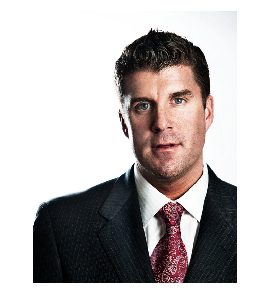

In [20]:
img_f = fnames[3]
img = open_image(img_f)
img.show(figsize=(5,5))

## get_y_fn Function
We use this function to obtain the name of the corresponding mask of the image. It adds _matte to the end of a file name and searches for the image in the path path_lbl

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_matte{x.suffix}'

We use a special function open_mask which reads the image as a mask file and displays the segmented sections.

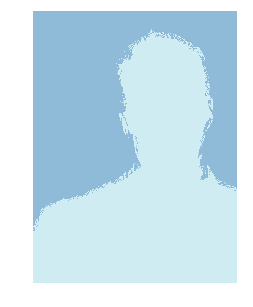

In [22]:
mask = open_mask(get_y_fn(img_f), div=True) 
# we pass div=True. The image has pixel values in range 0-255. Since this is a binary classification,
# we want the values to be either 0 or 1. So we divide all the values by 255.
mask.show(figsize=(5,5))

In [23]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([800, 600]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]]]))

# Model

In [34]:
# Hyperparameters

# We first train the model on images of half the resolution
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

# We use accuracy thresh metric as y_true and y_pred are same size (size of the image)
acc_02 = partial(accuracy_thresh, thresh=0.5, sigmoid=False)
f_score = partial(fbeta, thresh=0.5)
metrics = [acc_02, f_score]

wd=1e-2

using bs=8, have 9121MB of GPU RAM free


In [0]:
# We use a custom class for the labels as we want to pass div=True so that labels have value 0 or 1
class SegLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, convert_mode='L', div=True)

class SegItemListCustom(SegmentationItemList):
    _label_cls = SegLabelListCustom

codes = ['0','1']
src = (SegItemListCustom.from_folder(path)
       .split_by_folder(train='train', valid='valid') # train and validation images are in separate folders
       .label_from_func(get_y_fn, classes=codes)) # all the masks are in a single folder and accessed using this function

data = (src.transform(get_transforms(), size=size, tfm_y=True) # we pass tfm_y=True, as we want the augmentations to reflect on the masks as well
        .databunch(bs=bs)
        .normalize(imagenet_stats))

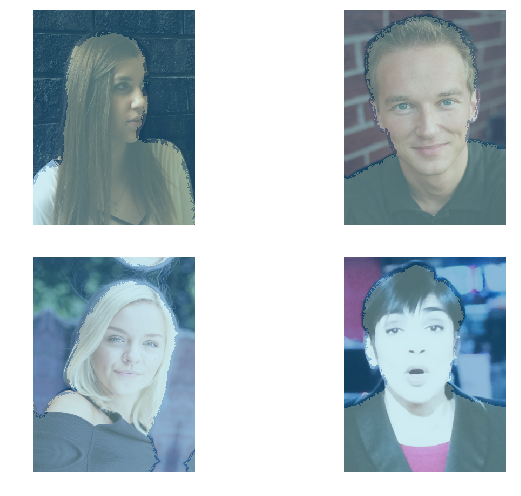

In [36]:
# Display random images and their masks from the train folder

data.show_batch(2, figsize=(10,7))

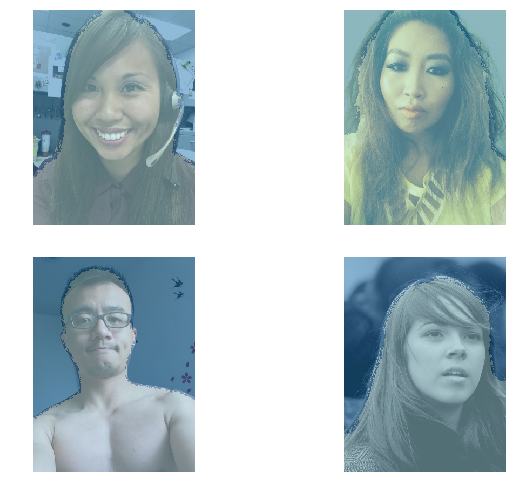

In [37]:
# Display images and their masks from the validation folder

data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

We use a pretrained u_net model based on resnet34.

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


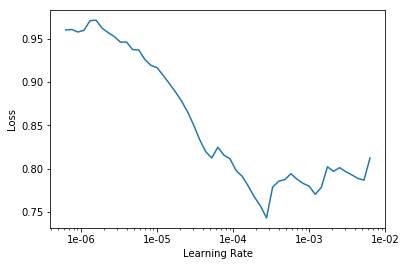

In [39]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [0]:
lr=1e-4

In [41]:
# We train the model for 5 epochs
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.237112,0.179287,0.511482,0.623310,02:59
1,0.140374,0.116150,0.496379,0.586328,03:04
2,0.121555,0.118422,0.501232,0.575835,03:05
3,0.103070,0.086044,0.499776,0.575897,03:04
4,0.090632,0.081464,0.499489,0.575897,03:04


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

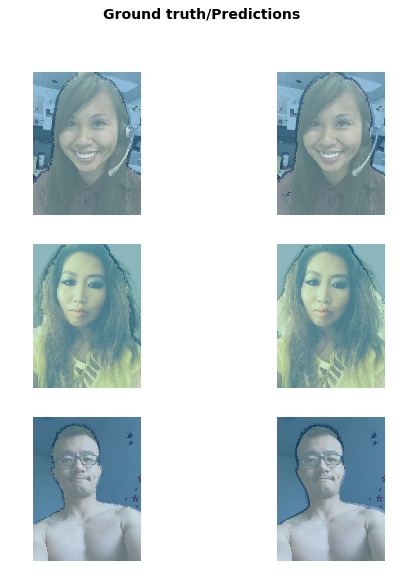

In [44]:
# Display the results of the model

learn.show_results(rows=3, figsize=(8,9))

On visual inspection, we can see that the model performs very well on creating a segmented on our images.

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

We unfreeze the model and train it for few more epochs for fine-tuning.

In [47]:
learn.fit_one_cycle(3, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.080321,0.077941,0.499366,0.575873,03:08
1,0.077628,0.078968,0.501316,0.574429,03:10
2,0.079087,0.074801,0.497613,0.575432,03:11


In [0]:
learn.save('stage-2');

# Go Big

Now we train the model on the original resolution of the images.

In [56]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=3, have 8841MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


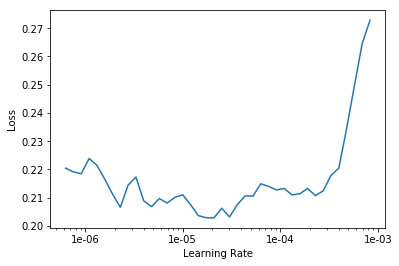

In [61]:
learn.lr_find()
learn.recorder.plot(skip_end=10)

In [0]:
lr=1e-6

In [63]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.193505,0.161811,0.499750,0.574160,12:47
1,0.164935,0.149849,0.497308,0.573734,12:50
2,0.147213,0.144774,0.497496,0.573287,12:50


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [69]:
learn.fit_one_cycle(1, lrs)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.147699,0.135328,0.498491,0.573848,13:14


In [0]:
learn.save('stage-2-big')

We save the models on Google Drive

In [71]:
shutil.copy('data/models/stage-1.pth', 'drive/My Drive/Portrait Segmentation/stage-1.pth')

'drive/My Drive/Portrait Segmentation/stage-1.pth'

In [72]:
shutil.copy('data/models/stage-1-big.pth', 'drive/My Drive/Portrait Segmentation/stage-1-big.pth')

'drive/My Drive/Portrait Segmentation/stage-1-big.pth'

In [0]:
learn.load('stage-2-big');

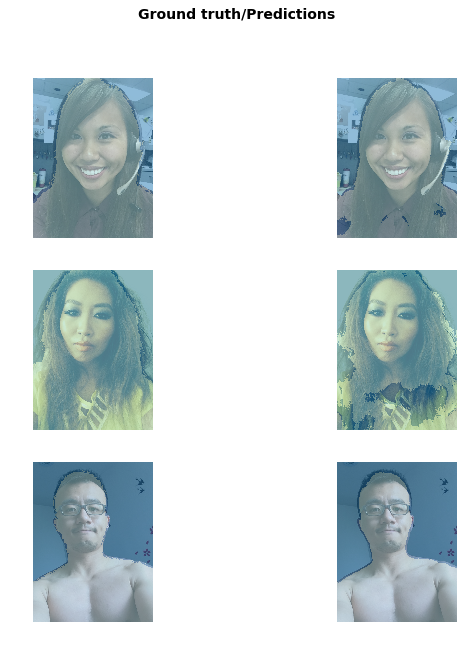

In [75]:
learn.show_results(rows=3, figsize=(10,10))

### Although the model has only 50% accuracy, it is able to predict the mask really well. This suggests that there is some problem with the calculation of accuracy metric. We need further investigation on this problem.###

# CelebA Dataset

We want to use this trained model (Transfer Learning) to evaluate the results on CelebA Dataset.
- We have randomly sampled 10 examples from CelebA dataset and we check how well our model performs.

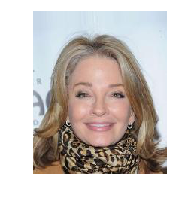

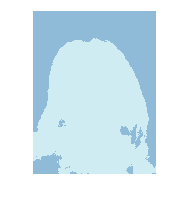

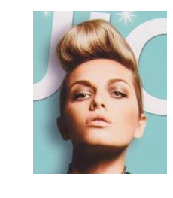

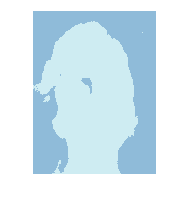

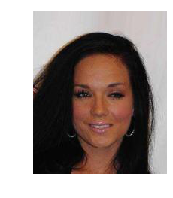

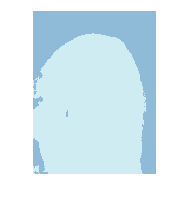

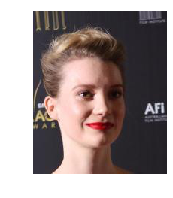

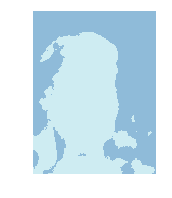

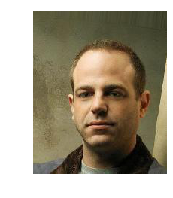

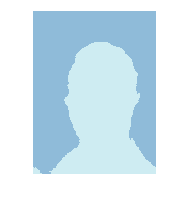

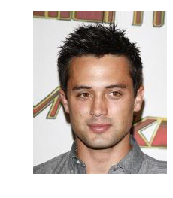

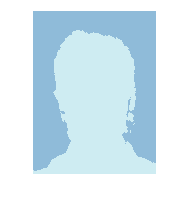

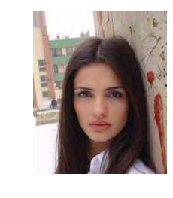

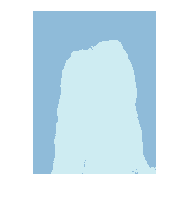

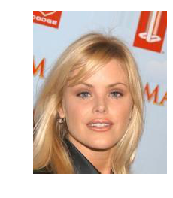

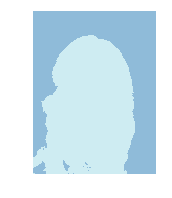

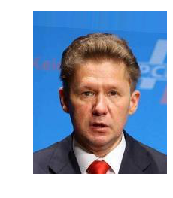

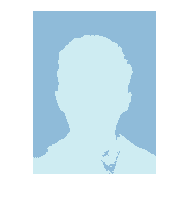

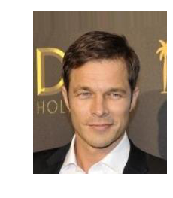

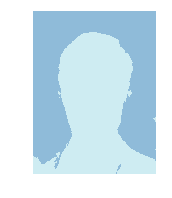

In [84]:
for i in range(10):
  img = open_image('0' + str(i) + '.jpg')
  pred_img = learn.predict(img)
  img.show()
  pred_img[0].show()

Our model is able to segment the image and produce a good mask for these images. Hence, this model can be applied to the entire CelebA dataset.